# Metody Obliczeniowe w Nauce i Technice Laboratorium 9
## Zastosowania DFT
### Paweł Gorgolewski

In [27]:
from PIL import Image, ImageOps, ImageFont, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import string
from collections import defaultdict

## 1. Analiza obrazów

In [28]:
def find_patterns(original_image, pattern_image, min_val, extra_val_tranform=None):
    def prepare_img(img_path):
        img = Image.open(img_path)
        gray_scale = img.convert('L')
        inverted = ImageOps.invert(gray_scale)
        transformed = np.abs(np.array(inverted) - extra_val_tranform) if extra_val_tranform is not None else np.array(inverted)
        return img, np.swapaxes(transformed, 0, 1)

    def show_phase_and_amplitude(img_after_dft):
        img = np.swapaxes(np.array(img_after_dft), 0, 1)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        ax1.imshow(np.angle(img), cmap='gray')
        ax1.set_title('PHASE')
        ax2.imshow(np.log(abs(img)), cmap='gray')
        ax2.set_title('AMPLITUDE')
        fig.tight_layout()
        plt.show()

    img, img_prepared = prepare_img(original_image)
    width, height = img.size
    dft = np.fft.fft2(img_prepared)   # fourier transformation
    show_phase_and_amplitude(dft)

    pattern_img, pattern_prepared = prepare_img(pattern_image)

    C = np.real(np.fft.ifft2(np.multiply( dft, np.fft.fft2(np.rot90(pattern_prepared, 2), s=(width, height))))) # counting corelation
    C_min_v = min_val * (np.max(C) - np.min(C)) + np.min(C)   # min_val adjust

    pattern_width, pattern_height = pattern_img.size
    img_comp = img.load()
    for x, y in np.argwhere(C >= C_min_v):
        for pw in range(pattern_width):
            for ph in range(pattern_height):
                r, g, b = img_comp[x-pw, y-ph]
                img_comp[x-pw, y-ph] = (r+100, g-50, b+100)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.show()

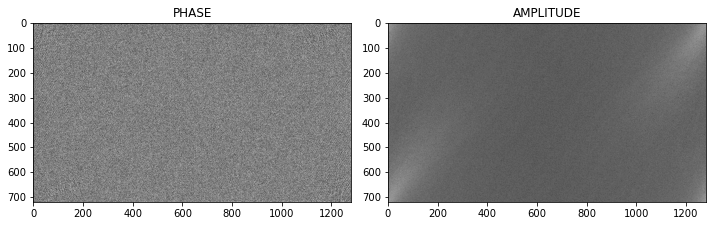

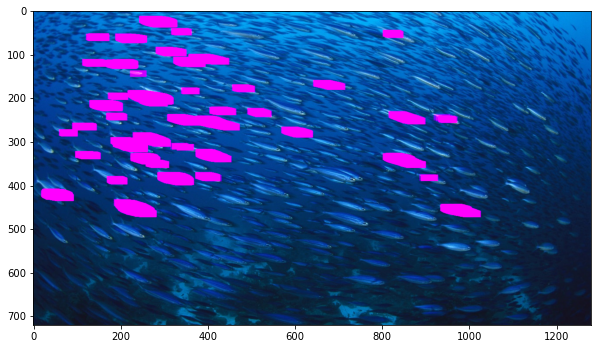

In [29]:
find_patterns('Lab9_school.jpg', 'Lab9_fish1.png', 0.6, extra_val_tranform=120)

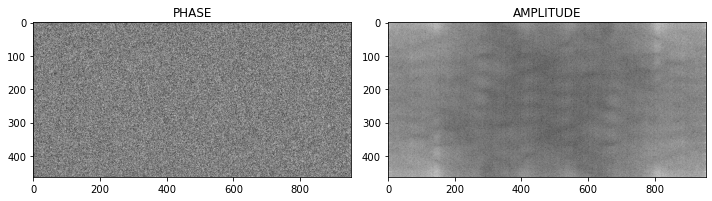

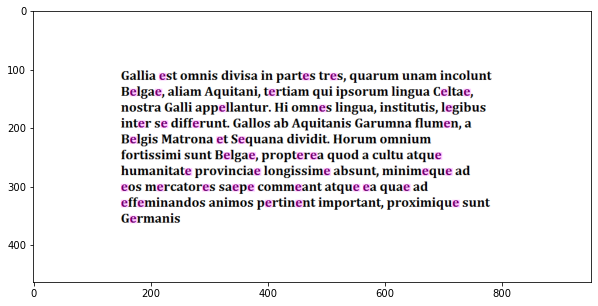

In [30]:
find_patterns('Lab9_galia.png', 'Lab9_galia_e.png', 0.9)